# Project:  Articles Classification

## Table of Contents

<ul>
<li><a href="#PS">Problem Statement</a></li>
<li><a href="#DG">Data Gathering</a></li>
<li><a href="#A&C">Assessing & Cleaning</a></li>
<li><a href="#SP">Splitting the Data</a></li>
<li><a href="#TC">Data Transformation & Classification</a></li>
</ul>

<a id="PS"><a/>
# Problem Statement

>Classifying the type of the acticles based on the content of its body by testing different Algorithms.

<a id="DG"><a/>
# Data Gathering

In [1]:
#Importing the needed libraries
import urllib.request
import json 
import pandas as pd
%matplotlib inline

In [2]:
#Reading Json URL
response = urllib.request.urlopen('https://knowledge-officer-assessments.s3.us-east-2.amazonaws.com/machine-learning/assignment%231/articles.json')
data = json.loads(response.read())
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
#Transforming the data from json to DataFrame
data_new = pd.DataFrame.from_dict(data)
print(data_new.columns)
data_new

Index(['body', 'title', 'category'], dtype='object')


,body,title,category
0,Protecting Netflix Viewing Privacy at Scale\r\...,Protecting Netflix Viewing Privacy at Scale,Engineering
1,Introducing Winston — Event driven Diagnostic ...,Introducing Winston - Event driven Diagnostic ...,Engineering
2,Performance & Usage at Instagram\r\n\r\nAt Ins...,Performance & Usage at Instagram,Engineering
3,The simple example of calculating and formatti...,Refactoring a javascript video store,Engineering
4,Billing applications have transactions that ne...,Netflix Billing Migration to AWS - Part III,Engineering
...,...,...,...
2476,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",Startups & Business
2477,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,Startups & Business
2478,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,Engineering
2479,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,Product & Design


### Now we have 3 features ['body','title','category'], we need to fit our model with the appropriate words using "body" or "title" so the model can be able to categorize the new articles to the correct category which they belong to.

<a id='A&C'><a/>
# Data Assessing & Cleaning

In [4]:
#checing the missing values and the data type
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2481 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB


In [5]:
data_new.dropna(subset=['body'],inplace=True)
data_new.drop_duplicates(subset=['body'],inplace=True)

In [6]:
#Councting the number of each entries in category column.
data_new['category'].value_counts()

Startups & Business    1017
Product & Design        833
Engineering             530
Name: category, dtype: int64

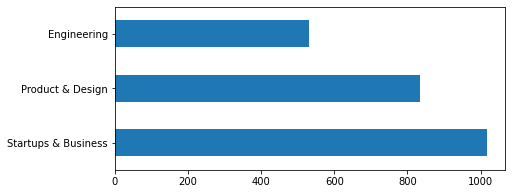

In [7]:
#ploting the number of the enteries.
data_new['category'].value_counts().plot.barh(figsize=(7,3));

### The classes are not equal so we will be sampling the same size of sample from the data for each class,to make the data balanced when we are fitting the model.

In [8]:
#Sampling the same sample size of "Engineering" for "Product & Design" & "Startups & Business"

product_data = data_new[data_new['category'] == 'Product & Design'].sample(n=530, replace=False)
startup_data = data_new[data_new['category'] == 'Startups & Business'].sample(n=530, replace=False)

In [9]:
#Filtering the data then concatenating the data into 1 DataFrame and shuffle all of the data again

engineering_data = data_new[data_new['category'] == 'Engineering']
balanced_data = pd.concat([product_data,startup_data,engineering_data]).sample(frac=1,replace=False)
balanced_data = balanced_data.reset_index()

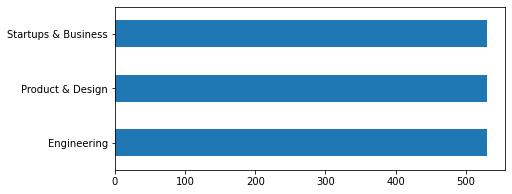

In [10]:
#Plotting the data again after sampling
balanced_data['category'].value_counts().plot.barh(figsize=(7,3));

In [11]:
balanced_data.head(10)

,index,body,title,category
0,341,"A Proposed Recipe for Designing, Building and ...","A Proposed Recipe for Designing, Building and ...",Engineering
1,323,This is a write up of my notes (plus some furt...,JavaScript and Functional Programming,Engineering
2,1970,524 SHARES Twitter Linkedin Facebook\r\n\r\nIn...,The Power of Data Network Effects,Startups & Business
3,1635,Merging the gaps between data science and engi...,What is a productive data engineering team?,Engineering
4,2128,The energy was high at CloudApp’s Monday morni...,Data-Driven Customer Retention,Product & Design
5,282,"After hearing about Pokemon Go, I spent a good...",Thoughts on Pokemon Go,Startups & Business
6,495,The Importance of Listening to Your Customers ...,The Importance of Listening to Your Customers ...,Product & Design
7,863,React Native at Instagram\n\nReact Native has ...,React Native at Instagram,Engineering
8,1476,"Visual aesthetics are very personal, often sub...",Personalized Aesthetics: Recording the Visual ...,Engineering
9,669,A Product Manager’s Guide to Strong Team Commu...,A Product Manager’s Guide to Strong Team Commu...,Product & Design


In [12]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1590 non-null   int64 
 1   body      1590 non-null   object
 2   title     1590 non-null   object
 3   category  1590 non-null   object
dtypes: int64(1), object(3)
memory usage: 49.8+ KB


### We will be dropping the Index column from our DataFrame and the Title column as we are going to tokanize the Body only to fit it into our model.


In [13]:
#We will be dropping the Index Title from our Data.
new_data = balanced_data.drop(['index','title'],axis=1)

In [14]:
new_data.head(10)

,body,category
0,"A Proposed Recipe for Designing, Building and ...",Engineering
1,This is a write up of my notes (plus some furt...,Engineering
2,524 SHARES Twitter Linkedin Facebook\r\n\r\nIn...,Startups & Business
3,Merging the gaps between data science and engi...,Engineering
4,The energy was high at CloudApp’s Monday morni...,Product & Design
5,"After hearing about Pokemon Go, I spent a good...",Startups & Business
6,The Importance of Listening to Your Customers ...,Product & Design
7,React Native at Instagram\n\nReact Native has ...,Engineering
8,"Visual aesthetics are very personal, often sub...",Engineering
9,A Product Manager’s Guide to Strong Team Commu...,Product & Design


In [15]:
#Replacing the new line with spaces
new_data['body'] = new_data['body'].replace('\r',' ').replace('\n',' ')
new_data['body'].dtype

dtype('O')

### As the data has a lot Regex and Symbols that need to be parsed and stopwords to be removed before the modeling step. We will be defining a new Function to clean the body column and then we will apply it to the column.

In [16]:
#Imporing Regex and nltk Libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Defining all the needed variables to be cleaned

replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
bad_symbols_re = re.compile('[^0-9a-z #+_]')
remove_num_re = re.compile('[\d+]')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#Defining a function that clean the text.

def clean_text(text):
    text = text.lower()  #lowercase text
    text = replace_by_space_re.sub(' ', text) #replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace('x', '') #Remove the X values
    text = text.replace('\r',' ').replace('\n',' ') #Remove the new lines values
    text = remove_num_re.sub('', text) #removing numbers
    text = bad_symbols_re.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text

In [18]:
#Appling the clean_text function on the body column.
new_data["body"] = new_data["body"].apply(clean_text)

In [19]:
new_data.head(15)

,body,category
0,proposed recipe designing building testing mic...,Engineering
1,write notes plus research kyle simpsons ecelle...,Engineering
2,shares twitter linkedin facebook furiously com...,Startups & Business
3,merging gaps data science engineering side lea...,Engineering
4,energy high cloudapps monday morning allhands ...,Product & Design
5,hearing pokemon go spent good part weekend pla...,Startups & Business
6,importance listening customers david cancel ma...,Product & Design
7,react native instagram react native come long ...,Engineering
8,visual aesthetics personal often subconscious ...,Engineering
9,product managers guide strong team communicati...,Product & Design


## The data is cleaned and ready to be splitted to train, validation and test sets.

<a id="SP"><a/>
# Splitting the Data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
#split the data to X and y then to 60% train, 15% validation and 15% test
X = new_data['body']
y = new_data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=2)

In [22]:
#Saving the data to Excel files
train = pd.concat([X_train, y_train], axis=1)
train.to_excel('Train.xlsx')

validation = pd.concat([X_val, y_val], axis=1)
validation.to_excel('Validation.xlsx')

test = pd.concat([X_test, y_test], axis=1)
test.to_excel('Test.xlsx')

In [23]:
print(train.shape)
print(validation.shape)
print(test.shape)
print(new_data.shape)

(1148, 2)
(203, 2)
(239, 2)
(1590, 2)


<a id='TC'><a/>
# Data Transformation & Classification

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [25]:
SVC = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
               ('clf', OneVsRestClassifier(LinearSVC(),n_jobs=1))])

In [26]:
SVC.fit(X_train, y_train)

y_pred = SVC.predict(X_val)

accuracy = accuracy_score(y_val,y_pred)
print(accuracy)

0.8866995073891626


In [27]:
final_prediction = SVC.predict(X_test)

model_accuracy = accuracy_score(y_test,final_prediction)
print(model_accuracy)

0.9121338912133892
